# Large-scale Distributed $k$-means Algorithm

In this Notebook, we'll focus on the development of a simple distributed algorithm. As for the Notebook on SGD, we focus on iterative algorithms, which eventually converge to a desired solution.

In what follows, we'll proceed with the following steps:

* We first introduce formally the $k$-means algorithm
* Then we focus on a serial implementation. To do this, we'll first generate some data using scikit. In passing, we'll also use the $k$-means implementation in scikit to have a baseline to compare against.
* Subsequently, we will focus on some important considerations and improvements to the serial implementation of $k$-means.
* At this point, we'll design our distributed version of the $k$-means algorithm using pyspark, and re-implement the enhancements we designed for the serial version 

#### References:
* https://en.wikipedia.org/wiki/K-means_clustering
* http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/kmeans.ipynb
* https://apache.googlesource.com/spark/+/master/examples/src/main/python/kmeans.py
* https://github.com/castanan/w2v/blob/master/ml-scripts/w2vAndKmeans.py


#### Preamble code

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs
import time

# Preliminaries: the $k$-means algorithm

$k$-means clustering aims to partition $n$ $d-$dimensional observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.
The problem is computationally difficult (NP-hard); however, there are efficient heuristic algorithms that are commonly employed and converge quickly to a local optimum. In this Notebook we'll focus on one of them in particular: the Lloyd algorithm.

The $k$-means problem can be formalized as follows. Given a set of observations $(x_1, x_2, \cdots, x_n)$, where each observation is a $d$-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k \leq n$ sets $S = \{S_1, S_2, \cdots, S_k\}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). 
The objective is to find:

$$
\arg \min_S \sum_{i=1}^{k} \sum_{x \in S_i} || \boldsymbol{x} - \boldsymbol{\mu_i} ||^2
$$

The most common algorithm uses an iterative refinement technique. Given an initial set of $k$ centroids $\mu_1^{(1)}, \cdots, \mu_k^{(1)}$ , the algorithm proceeds by alternating between two steps: in the **assignment step**, observations are associated to the closest **centroid**, in terms of squared Euclidean distance; in the **update step** new centroids are computed based on the new points associated to each centroid. Note: $\mu_i^{(t)}$ stands for the $i$-th centroid as of the $t$-th iteration. So $\mu_1^{(1)}$ is the centroid 1 at iteration 1.

## Algorithm pseudo-code
It is important to work on a principled approach to the design of large-scale algorithms, and this starts with using good data structures and scientific libraries, such as ```numpy``` and ```scipy```. In particular, we will focus on the use of ```numpy``` arrays, which come with efficient methods for array operations. A pseudo-code for the $k$-means algorithm is specified below:

```python
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    centroids = X[rand_indices]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        # assign each data point to the closest centroid
        cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = ...
        
        # STOP CONDITION
        # if centroids == new_centroids => stop
 
    
```

# Synthetic data generation: working in bi-dimensional spaces

Next, we use sklearn to generate some synthetic data to test our algorithm.

In [52]:
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


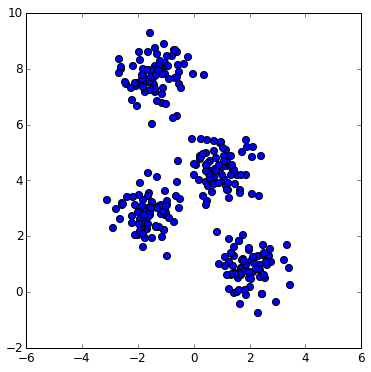

In [53]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter(X[:, 0], X[:, 1], s = 50)
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of k-means, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform k-means clustering. The function should accept as inputs: the training data x, the number of clusters k, and the iteration budget you allocate to the algorithm. Additional arguments might include the use of a random seed to initialize centroids.</li>
    <li>The function should output the centroids, and the cluster assignment, that is, to which centroid each data point is assigned to</li>
    <li> Optionally, keep track of the position of the centroids, for each iteration.</li>
</ul>

<br>
Once the ```kmeans``` function is defined, you can generate input data according to the cell above, that uses scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> Print the number of data points that belong to each cluster</li>
    <li> Plot the clustered data points:</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

In [8]:
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    nRow, nCol = X.shape

    # randomly choose k data points as initial centroids
    if seed is not None:
        np.random.seed(seed)
    
    rand_indices = np.random.choice(nRow, size = k, replace = False)
    centroids = X[rand_indices]
    #print("initial centroids ", centroids)
    centroid_position = [centroids]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = pairwise_distances(X, centroids, metric = 'euclidean')
        #print("distance_matrix iter n. ", itr, distance_matrix)
        # row Index = data point Index; col Index = centroid Index; value=distance 
        
        # assign each data point to the closest centroid
        cluster_assignment = np.argmin(distance_matrix, axis = 1)
        #print("cluster_assignment iter n. ", itr, cluster_assignment)
        # array Index = data point Index; array value = closest centroid Index
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([X[cluster_assignment == i].mean(axis = 0) for i in range(k)])
        #print("new_centroids iter n. ", itr, new_centroids)
        
        # STOP CONDITION
        # if centroids == new_centroids => stop
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        centroid_position.append(centroids)
    
    centroid_position = np.array(centroid_position) 
    print("stopped at " + str(len(centroid_position)) +" iterations")
    
    return centroids, cluster_assignment, centroid_position

In [10]:
k=4
maxiter = 100

centroids_result, cluster_assignment_result, track = kmeans(X, k, maxiter, seed=None)

# we can count occurrences of each cluster label
count = np.bincount(cluster_assignment_result)

#Print the number of data points that belong to each cluster
for i in range(len(count)):
    print("cluster n. ", i, "  has ", count[i],"points")

stopped at 8 iterations
cluster n.  0   has  364 points
cluster n.  1   has  378 points
cluster n.  2   has  377 points
cluster n.  3   has  381 points


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


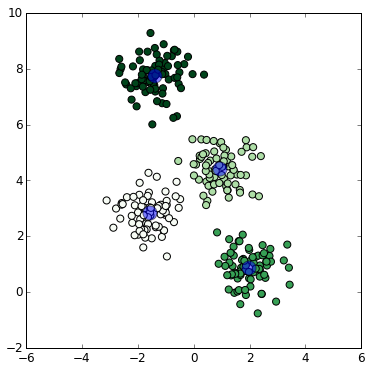

In [42]:
# plot the cluster and cluster's centroid
plt.scatter(X[:, 0], X[:, 1], s = 50, c = cluster_assignment_result, cmap = 'Greens_r')
plt.scatter(centroids_result[:, 0], centroids_result[:, 1], s = 200, alpha = 0.5)
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

In [43]:
#group centroids by clusters
transposeTrack = track.transpose()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


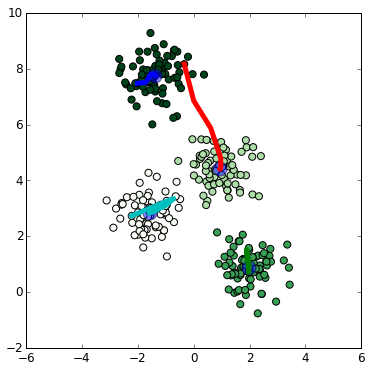

In [44]:
# plot the cluster and cluster's centroid
plt.scatter(X[:, 0], X[:, 1], s = 50, c = cluster_assignment_result, cmap = 'Greens_r')
plt.scatter(centroids_result[:, 0], centroids_result[:, 1], s = 200, alpha = 0.5)

plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')

#plot the track of centroids
for j in range(k):
    plt.plot(transposeTrack[0][j], transposeTrack[1][j], lw =5)
    
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Use the built-in k-means implementation in sklearn and determine centroids and clusters.

Follow the guidelines below:

<ul>
    <li> Use the KMeans algorithm from sklearn</li>
    <li> Use the fit_predict method to cluster data</li>
    <li> Use the cluster_centers_ method to retrieve centroids</li>
</ul>

The output of your cell should contain the following information:
<ul>
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

In [45]:
kmeans2= KMeans(n_clusters=4, max_iter=20)
clusters=kmeans2.fit(X)
clusPoints=kmeans2.fit_predict(X)
centroids=clusters.cluster_centers_

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


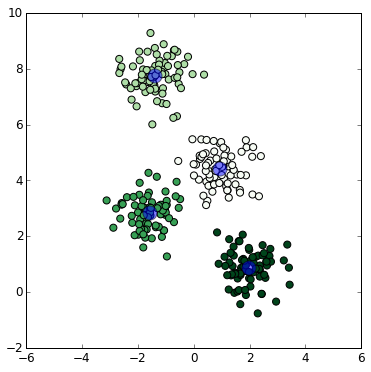

In [46]:
# plot the clusters and clusters' centroids

plt.scatter(X[:, 0], X[:, 1], s = 50, c = clusPoints, cmap = 'Greens_r')
plt.scatter(centroids[:, 0], centroids[:, 1], s = 200, alpha = 0.5)
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Use the sklearn dataset API to generate alternative synthetic data to test your k-means algorithm implementation.

Follow the guidelines from this document: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py


The output of your cell should contain the following information:
<ul>
    <li> Plot the new synthetic dataset you generated
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

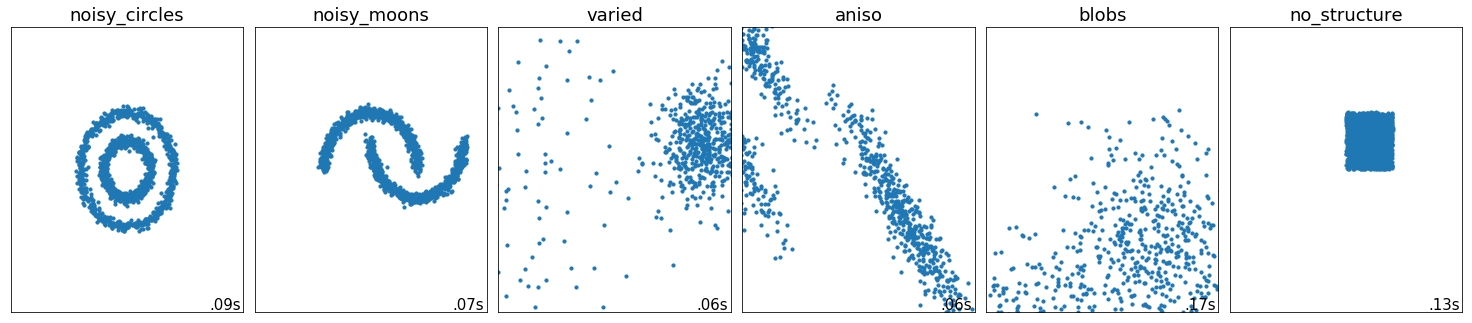

In [6]:
import time
import warnings

import numpy as np


import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=2)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]
Names=["noisy_circles", "noisy_moons", "varied", "aniso", "blobs", "no_structure"]
plot_num=1
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    t0=time.time()
    X, y = dataset
    plt.subplot(3, len(datasets), plot_num)
    plt.title(Names[i_dataset], size=18)
    #colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']), 1500)))
    plt.scatter(X[:, 0], X[:, 1], s=10) #, color=colors[y])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    t1=time.time()
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),transform=plt.gca().transAxes, size=15,horizontalalignment='right')
    plot_num+=1
plt.show()


stopped at 8 iterations
stopped at 23 iterations
stopped at 11 iterations
stopped at 12 iterations
stopped at 20 iterations
stopped at 18 iterations


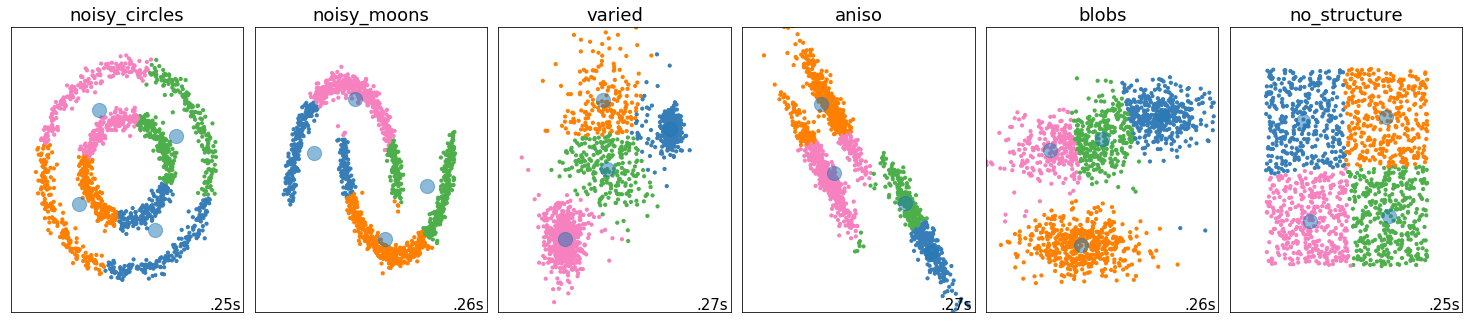

In [12]:
import time
import warnings

import numpy as np


import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=2)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

Names=["noisy_circles", "noisy_moons", "varied", "aniso", "blobs", "no_structure"]
    
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    t0 = time.time()
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    centroids_result, cluster_assignment_result, track = kmeans(X, k, maxiter, seed=None)


    y_pred = cluster_assignment_result

    plt.subplot(3, len(datasets), plot_num)
    plt.title(Names[i_dataset], size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    plt.scatter(centroids_result[:, 0], centroids_result[:, 1], s = 200, alpha = 0.5)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    t1 = time.time()
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),transform=plt.gca().transAxes, size=15,horizontalalignment='right')
    plot_num += 1

plt.show()

***

# A simplified analysis of algorithm convergence

One well-known weakness of $k$-means is that the algorithm's performance is closely tied with the randomly generated initial centroids' quality. If the algorithm starts with a set of bad inital centers, it will get stuck in a local minimum.

Instead of taking a formal approach to study the convergence of $k$-means, let's study it with an experimental approach. One thing we can do is to build a measure of clustering quality: intuitively, a good clustering result should produce clusters in which data points should be very close to their centroids, and very far from other centroids. In this Notebook, we'll look at a metric called the **total within Sum of Squares**, which is sometimes referred ot as heterogeneity. Mathematically, we define heterogeneity as:

$$
\mathcal{H} = \sum_{j=1}^{k} \sum_{i: z_i=j} || \boldsymbol{x_i} - \boldsymbol{\mu_j}||_{2}^{2}
$$

Where $k$ denotes the total number of clusters, $x_i$ is the $i$-th data point, $\mu_j$ is the $j$-th centroid, and $|| \cdot ||_{2}^{2}$ denotes the squared L2 norm (Euclidean distance) between the two vectors.

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Modify your own version of k-means, to compute heterogeneity as defined above.

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [54]:
def kmeans_heterogeous(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    nRow, nCol = X.shape

    # randomly choose k data points as initial centroids
    if seed is not None:
        np.random.seed(seed)
    
    rand_indices = np.random.choice(nRow, size = k)
    centroids = X[rand_indices]

    #to keep track of the position of each centroid
    centroid_position = [centroids]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = pairwise_distances(X, centroids, metric = 'euclidean')
        #print("distance_matrix iter n. ", itr, distance_matrix)
        # row Index = data point Index; col Index = centroid Index; value=distance 
        
        # assign each data point to the closest centroid
        cluster_assignment = np.argmin(distance_matrix, axis = 1)
        #print("cluster_assignment iter n. ", itr, cluster_assignment)
        # array Index = data point Index; array value = closest centroid Index
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([X[cluster_assignment == i].mean(axis = 0) for i in range(k)])
        #print("new_centroids iter n. ", itr, new_centroids)
        
        # STOP CONDITION
        # if centroids == new_centroids => stop
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        centroid_position.append(centroids)
        
    heterogeneity = 0
    for i in range(k):
        # note that pairwise_distance only accepts 2d-array
        cluster_data = X[cluster_assignment == i]
        distances = pairwise_distances(cluster_data, [centroids[i]], metric = 'euclidean')
        heterogeneity += np.sum(distances ** 2)
    
    centroid_position = np.array(centroid_position) 
    print("stopped at " + str(len(centroid_position)) +" iterations")
    
    return centroids, cluster_assignment, centroid_position, heterogeneity

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.

Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

Add your personal comment about the convergence properties of the $k$-means algorithm.

</div>

In [71]:
k=4
maxiter = 100    
    
heterogeneity_kmeans = {}

for seed in [0, 711, 5010, 8181, 120000]:
    _, _, _, heterogeneity = kmeans_heterogeous(X, k, maxiter, seed = seed)
    heterogeneity_kmeans[seed] = heterogeneity
    print('seed = {}, heterogeneity = {}'.format(seed, heterogeneity_kmeans[seed]))

stopped at 6 iterations
seed = 0, heterogeneity = 212.00599621083518
stopped at 3 iterations
seed = 711, heterogeneity = 212.00599621083518
stopped at 7 iterations
seed = 5010, heterogeneity = 212.00599621083518
stopped at 4 iterations
seed = 8181, heterogeneity = 523.7150139149792
stopped at 5 iterations
seed = 120000, heterogeneity = 528.5562600476272


***

### Question 5: Comments

* It seems that convergence is reached for heterogeneity = 212.00599621083518
* Apparently, this minimum is not reached for seed = 8181 and seed = 120000.
* So, k-means can be sometimes stuck at a bad local minimum.

# A technique for a smart centroid initialization: $k$-means++

One effective way to produce good initial centroids to feed to $k$-means is to proceed as follows: instead of randomly generating initial centroids, we will try to spread them out in our $d$-dimensional space, such that they are not "too close" to eachother. If you are interested in the details of this technique, you should refer to the link to the original research paper below: in summary, the $k$-means++ technique allows to improve the quality of the local optima in which $k$-means settles, and to reduce the average runtime of the algorithm.

k-means++: the advantages of careful seeding, by David Arthur and Sergei Vassilvitskii (Stanford University) https://dl.acm.org/citation.cfm?id=1283494

A simplified workflow of the $k$-means++ approach is as follows:


* Choose a data point at random from the dataset, this serves as the first centroid
* Compute the squared euclidean distance of all other data points to the randomly chosen first centroid
* To generate the next centroid, each data point is chosen with the probability (weight) of its squared distance to the chosen center in the current round, divided by the the total squared distance (this is just a normalization to make sure the probability adds up to 1). In other words, a new centroid should be as far as possible from the other centroids
* Next, recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the second iteration, compare the data point's distance between the first and second center and choose the smaller one)
* Repeat step 3 and 4 until we have $k$ initial centroids to feed to the $k$-means algorithm


<div class="alert alert-block alert-info">
<strong>Question 6.</strong> Modify your own version of k-means, to introduce the smart initialization technique described above. Don't forget to keep track of heterogeneity as well! The whole point is to measure if k-means++ really improves on this metric.

<br>
<br>

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute the initial clusters according to k-means++</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [62]:
def kmeansPP(X, k, maxiter, seed = None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    nRow, nCol = X.shape

    if seed is not None:
        np.random.seed(seed)
        

    # we choose the first centroid randomly
    centroids  = np.zeros((k, nCol))
    rand_index = np.random.choice(nRow)
    centroids[0] = X[rand_index]
        
    # compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(X, [centroids[0]], metric = 'euclidean').flatten()
    
    for i in range(1, k):
        # choose the next centroid, the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid
        prob = distances ** 2
        rand_index = np.random.choice(nRow, size = 1, p = prob / np.sum(prob))
        centroids[i] = X[rand_index]
            
        if i == k - 1:
            break
            
        # if we still need another cluster,
        # compute distances from the centroids to all data points
        # and update the squared distance as the minimum distance to all centroid
        distances_new = pairwise_distances(X, [centroids[i]], metric = 'euclidean').flatten()
        distances = np.min(np.vstack((distances, distances_new)), axis = 0)
        
    
    #to keep track of the position of each centroid
    centroid_position = [centroids]
    

    for itr in range(maxiter):
        # compute distances between each data point and the set of centroids
        # and assign each data point to the closest centroid
        distances_to_centroids = pairwise_distances(X, centroids, metric = 'euclidean')
        cluster_assignment = np.argmin(distances_to_centroids, axis = 1)

        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([X[cluster_assignment == i].mean(axis = 0) for i in range(k)])
        
        # if the updated centroid is still the same,
        # then the algorithm converged
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        
        centroid_position.append(centroids)
    
    centroid_position = np.array(centroid_position) 
    print("stopped at " + str(len(centroid_position)) +" iterations")
    
    heterogeneity = 0
    for i in range(k):
        # note that pairwise_distance only accepts 2d-array
        cluster_data = X[cluster_assignment == i]
        distances = pairwise_distances(cluster_data, [centroids[i]], metric = 'euclidean')
        heterogeneity += np.sum(distances ** 2)
    
    return centroids, cluster_assignment, centroid_position, heterogeneity

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Similarly to question 5, using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.
<br>
<br>


Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

<br>

One additional question to answer is the following: print the average heterogeneity for the baseline k-means algorithm, and the average heterogeneity when using the k-means++ initialization. Compare and comment with your own words.
</div>

In [72]:
k, maxiter = 4 , 100

heterogeneity_kmeanspp = {}

for seed in [0, 711, 5010, 8181, 120000]:
    _, _, _, heterogeneity = kmeansPP(X, k, maxiter, seed = seed)
    heterogeneity_kmeanspp[seed] = heterogeneity
    print( 'seed = {}, heterogeneity = {}'.format(seed, heterogeneity_kmeanspp[seed]) )

print("")
print('kmeans average: {}'.format( np.mean( list(heterogeneity_kmeans.values()) ) ))
print('kmeans++ average: {}'.format( np.mean( list(heterogeneity_kmeanspp.values()) ) ))

stopped at 3 iterations
seed = 0, heterogeneity = 212.00599621083518
stopped at 4 iterations
seed = 711, heterogeneity = 212.00599621083518
stopped at 14 iterations
seed = 5010, heterogeneity = 527.01295218203
stopped at 3 iterations
seed = 8181, heterogeneity = 212.00599621083518
stopped at 4 iterations
seed = 120000, heterogeneity = 212.00599621083518

kmeans average: 337.6578525190224
kmeans++ average: 275.00738740507416


### Question 7: Comments

* 337.6578525190224 > 275.00738740507416
* Therefore, in average, clustering heterogeneity is slightly worse (the heterogeneity is greater) for k-means than for k-means++
* So, it seems that k-means++ works better than k-mean with random initialization for centroids.
* However, it *doesn't mean* that with k-mean++, global minimum is always reached : indeed, it is not reached for seed = 5010. Moreover, the difference in heterogeneity is not that big between both algorithms.

# Determining the value of k: a simple and visual approach, called the Elbow method

Another problem of $k$-means is that we have to specify the number of clusters $k$ before running the algorithm, which we often don't know a priori. 
There are many different heuristics for choosing a suitable value for $k$, the simplest one being the **Elbow method**. Essentially, the idea is to run the $k$-means algorithm using different values of $k$ and plot the corresponding heterogeneity. This measure will decrease as the number of clusters increases, because each cluster will be smaller and tighter. 
By visual inspection of the plot heterogeneity vs. $k$, we will (hopefully!) see that the curve flattens out at some value of $k$: this is what we call an "elbow", and we'll select the value of $k$ corresponding to the "elbow" position.


<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Using the k-means algorithm you implemented, including the smart initialization technique, collect into an array the value of heterogeneity as a function of the number of clusters k, where k is to be selected in the range [2,10].
<br>
<br>


Your output cell should contain:

<ul>
    <li>The plot of heterogeneity vs. k</li>
    <li>A discussion on your visual inspection of the curve, together with a justification for an appropriate choice of the value k</li>
</ul>
</div>

In [73]:
k_list = [k for k in range(2,10)]
heterogeneity_list = []
maxiter = 100

for i in range(len(k_list)):
    _, _, _, heterogeneity = kmeansPP(X, k_list[i], maxiter, seed = None)
    heterogeneity_list.append(heterogeneity)
print(heterogeneity_list)

stopped at 4 iterations
stopped at 16 iterations
stopped at 3 iterations
stopped at 4 iterations
stopped at 11 iterations
stopped at 6 iterations
stopped at 16 iterations
stopped at 11 iterations
[1190.7823593643443, 546.89115046262987, 212.00599621083518, 199.94961836846159, 178.43300108288594, 162.65435887926199, 136.61664010752165, 130.39260152588216]


***

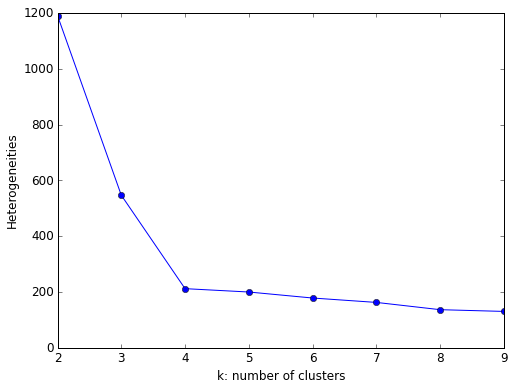

In [74]:
plt.plot(k_list, heterogeneity_list, marker = 'o')
plt.xlabel('k: number of clusters')
plt.ylabel('Heterogeneities')
plt.show()

### Questions 8: Comments

* The elbow method suggests to choose a number of clusters so that adding another cluster doesn't give much better modeling of the data.
* So, as we can see, the plot shows that we should choose 4 as our cluster number. It's the point where the graph shows an "elbow": the heterogeneity drops.

# Distributed $k$-means with PySpark

We're now ready to work on a distributed implmentation of the $k$-means algorithm, using the PySpark API.

By now, you should be rather familiar with the $k$-means algorithm, which means we can focus on its parallel and distributed design.

## Distributed algorithm pseudo code

The basic idea of distributed $k$-means is as follows: data points to be clustered should be stored as a distributed dataset, namely a RDD. As in the Notebook on distributed SGD, we will take a shortcut and avoid using HDFS RDDs: rather, we'll use sklearn to generate the data points, similary to the serial version of the algorithms, then use the ```parallelize()``` method to create an RDD, and determine the number of partitions.

We also need to manipulate the centroids array: indeed, all machines should hold a copy of the centroid vector, such that they can proceed independently and in parallel in the first phase of the $k$-means algorithm, that is the **assignment step**. Specifically, every worker has a set of data points, and it will use a copy of the centroid vector to compute cluster assignement: we compute the distance between each data point and each centroid, to assign data points to their closest centroid.

Once the assignement step is done, we need to recompute new centroids based on the assignement, that is, we execute the **update step**. Clearly, we will need to **shuffle** data over the network such that we will have, for each current centroid, the list of all data points that have been assigned to it. If you think about it, this problem should be familiar!! This is very similar to what we do in the Word Count example. As such, you will need to make sure the output of the update step is cast to a ```<key, value>``` type, where the key corresponds to a centroid identifier, and the value contains the list of data points associated to that centroid. The framework will take care of the distributed group by operation, and organize data according to the semantic of our algorithm.

**NOTE:** since we will (potentially) work on large dataset sizes, we don't want our algorithm to return the final assignement after convergence, for otherwise we would need to collect a large amount of data in the driver machine, which has a finite and somehow limited amount of RAM.

The pseudo code of the algorithm you need to implement is as follows:

```python
datapoints = # Use sklearn, as usual, and work on blobs
centroids = # Random initialization

for itr in range(maxiter): # This for loop is executed by the driver
    bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
    closest = datapoints.mapPartition(assignement_step) # This should happen in parallel
    
    centroids = closest.reduceByKey(update_step_sum). \ # This should happen in parallel
        map(update_step_mean). \ # This should happen in parallel
        collect() # Here we collect new centroids in the driver
```

As you can see from the pseudo code, you need to figure out how to implement the ```assignement_step``` function and the update_step function. For the latter, the pseudo code gives you a big hint! Remember what we discussed in class about computing the mean!

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Implement the distributed version of the k-means algorithm, following the guidelines in the pseudo code.
<br>
<br>

Your output cell should contain:

<ul>
    <li>The value of the centroids once the algorithm converges</li>
    <li>The total runtime of the distributed algorithm, in seconds</li>
    <li>A visualization of the data points and the computed centroids</li>
</ul>
</div>

In [19]:
from sklearn import cluster, datasets, mixture

def distributed_k_means(X, k, maxiter, seed=None):
    nRow , nCol = X.shape    
    
    if seed is not None:
        np.random.seed(seed)
    rand_indices = np.random.choice(nRow, size = k)
    # Random initialization
    centroids = X[rand_indices] 
    bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
    
    ########################################################
    #Iterable function: returns the index of the closest centroid of the point in the centroids array
    def closest_point(X):
        cluster_assignment = []
        resultmap = []
        
        for point in X:
            bestdist = (float("inf"))
            index = 0
            for j in range(len(bcCentroids.value)):
                c = bcCentroids.value[j]
                distance = np.linalg.norm( point - c )
                if distance < bestdist :
                    bestdist = distance
                    index = j
        
            resultmap.append( (index, (point,1)) )
    
        return resultmap
    #######################################################    
    
    
    #parallelize
    p_data = sc.parallelize(X, 4) 
    #p_data.cache() in order to kow RAM occupation
    
    for itr in range(maxiter): # This for loop is executed by the driver

        closest = p_data.mapPartitions(closest_point) # This should happen in parallel
        #closest is a list of tuples (a,b) where a is the index of the closest centroid of the point 'point' and b is for counting points assigned to each centroid = a key like in word count

        centroids_tmp = closest.reduceByKey(lambda keyvaluepair1, keyvaluepair2 : (keyvaluepair1[0] + keyvaluepair2[0] , keyvaluepair1[1] + keyvaluepair2[1]) )  # This should happen in parallel
        #centroids is a list of tuples (c,d) where c is the index of the centroid and d is the sum to count the number of points that are closest to the corresponding centroid
        
        new_centroids = centroids_tmp.map(lambda x : ( x[0] , x[1][0] / x[1][1])).collect()   # This should happen in parallel # Here we collect new centroids in the driver
            #x[1][0] is the 
            #tuples(e,f) where e is the index of the centroid and f is the mean on coordinates of its closest points
            
        
        for x in new_centroids:
            centroids[x[0]]= x[1]
       
        bcCentroids = sc.broadcast(centroids) # Use broadcast variables
                
    return (centroids)


Total runtime of distributed algorithm in seconds :  15.963635921478271
data size:  4912


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


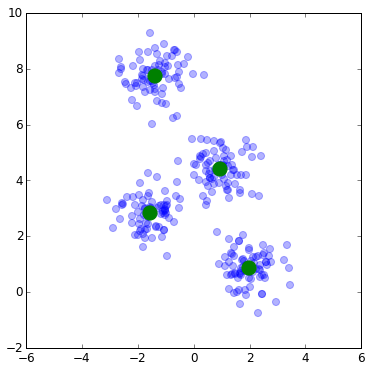

In [22]:
import time
import sys
from sklearn import cluster, datasets, mixture

X, y = make_blobs(n_samples = 300, centers = 4, random_state = 0, cluster_std = 0.6)
datasize = sys.getsizeof(X)

k, maxiter = 4, 100

t0 = time.time()
res_centroids = distributed_k_means (X,k, maxiter, seed=None)
t1 = time.time()

print("Total runtime of distributed algorithm in seconds : ", t1-t0)
print("data size: ", datasize)

################################## plot ##########################################################################

# plot the cluster and cluster's centroid
plt.scatter(X[:, 0], X[:, 1], s = 50, alpha = 0.3 , color='b')
plt.scatter(res_centroids[:, 0], res_centroids[:, 1], s = 200, color='g')
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()


<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Answer the following questions:
<br>
<br>
<ul>
    <li>How many partitions did you use? Why?</li>
    
    <li>What is the size of the dataset you generate? Did you cache the dataset? What's the RAM occupation?</li>
   
    <li>What is the size of the shuffle data over the network? How does it compare to the dataset size?</li>
    
</ul>
</div>

## Answer question 10:

* We used 4 partitions because we have 4 workers
* Our generated dataset has a size of 4912B. The dataset is already in memory so we don't need to cache it. However, to look at the RAM occupation, we need to cache the dataset just after the ```.parallelize``` method with ```.cache()``` method on the RDD . This method has then be removed and put in comment in the code above in the function ```distributed_k_means ```. We found that the RAM occupation is: 13 KB.
* The total size of our Shuffle data is 3.5 MB in total. This size is less than the dataset size. This is because in the ```reduceByKey``` method, values are grouped by key so there are less values used in memory

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison between serial and distributed implementations.
<br>
<br>
Given the dataset size you chose for your experiments, answer the following questions:
<ul>
    <li>Which is "faster", the serial or distributed implementation of k-means?</li>
  
    <li>What is a dataset size for which the distributed implementation is clearly faster than the serial one?</li>

    <li>What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?</li>
    
</ul>
</div>

## Answer question 11
* The serial implementation is faster than the distributed one. This can be checked in the graph below for different dataset sizes.
* The distributed implementation of kmeans is clearly faster than the serial one when the size of the dataset exceeds the RAM size.
* If the input dataset resided on disk, we would have to read it from HDFS and cache the RDD. Indeed if we did not cache it, the algorithm would have to read the data on disk for every operation, which would be slower. To avoid it, we would have to use the ```.cache()``` method. 

[1 3 7 9]
stopped at 2 iterations
[ 8 66 45  4]
stopped at 4 iterations
[883 136 304 889]
stopped at 7 iterations
[6453 3371 5721 9825]
stopped at 7 iterations
[11909 66120 19139 53480]
stopped at 11 iterations


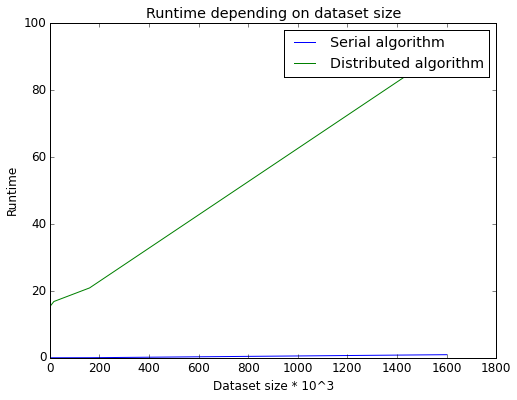

In [23]:
import time
import sys
from sklearn import cluster, datasets, mixture

sizes = []
times_serial = []
times_distrib = []

samples = [10, 100, 1000, 10000, 100000]
for n in samples :
    X, y = make_blobs(n_samples = n , centers = 4, random_state = 0, cluster_std = 0.6)
    datasize = sys.getsizeof(X)
    
    before_serial = time.time()
    _, _, _= kmeans(X, 4, 100, seed=None)
    after_serial = time.time()
    t_serial = after_serial - before_serial
    
    before_distrib = time.time()
    _ = distributed_k_means(X, 4, 100, seed=None)
    after_distrib = time.time()
    t_distrib = after_distrib - before_distrib
    
    sizes.append(datasize)
    times_serial.append(t_serial)
    times_distrib.append(t_distrib)
    
sizes = np.array(sizes)    
plt.title("Runtime depending on dataset size")
plt.plot(sizes/1000, times_serial, label = "Serial algorithm")
plt.plot(sizes/1000, times_distrib, label = "Distributed algorithm")
plt.xlabel("Dataset size * 10^3")
plt.ylabel("Runtime")
plt.legend()
plt.show() 